Research Paper: https://arxiv.org/abs/1904.05068

2019 paper

Dataset: CIFAR 100

"Relational Knowledge Distillation" introduces a novel perspective to knowledge distillation by emphasizing the importance of pairwise relationships in the feature space and using them to distill knowledge from teacher to student models.

Code Link: https://github.com/lenscloth/RKD




In [1]:
!pip install torch torchvision --quiet

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load Data - CIFAR100
def load_cifar100(batch_size=64):
    # Load Data - CIFAR100
    # Adjust mean and std values as appropriate
    mean = [0.5071, 0.4867, 0.4408]
    std = [0.2675, 0.2565, 0.2761]
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
    train_set = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
    test_set = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

train_loader, test_loader = load_cifar100()

100%|██████████████████████████████████████████████████████| 169001437/169001437 [00:05<00:00, 33499424.63it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
# Define the RKD distance and angle losses
def pairwise_distances(x, y):
    """
    Compute pairwise distances between the vectors in x and y
    Args:
    - x: A tensor of shape (batch_size, feature_dim)
    - y: A tensor of shape (batch_size, feature_dim)
    Returns:
    - pairwise_distances: Tensor of shape (batch_size, batch_size)
    """
    inner_product = torch.mm(x, y.t())
    x_norm = torch.norm(x, dim=1, keepdim=True)
    y_norm = torch.norm(y, dim=1, keepdim=True)
    distances = x_norm**2 - 2.0 * inner_product + y_norm.t()**2
    return distances

def DD_loss(student, teacher):
    """
    Distance-wise Distillation Loss
    """
    student_distances = pairwise_distances(student, student)
    teacher_distances = pairwise_distances(teacher, teacher)

    # We scale down the teacher distances to make it in range with the student's
    teacher_distances = teacher_distances / teacher_distances.detach().data.mean()
    student_distances = student_distances / student_distances.detach().data.mean()

    loss = F.mse_loss(student_distances, teacher_distances)
    return loss

def pairwise_angles(x, y):
    """
    Compute pairwise angles between the vectors in x and y
    """
    norm_x = torch.norm(x, dim=1, keepdim=True)
    norm_y = torch.norm(y, dim=1, keepdim=True)
    normalized_x = x / norm_x
    normalized_y = y / norm_y
    cosine_similarity = torch.mm(normalized_x, normalized_y.t())
    return cosine_similarity

def AD_loss(student, teacher):
    """
    Angle-wise Distillation Loss
    """
    student_angles = pairwise_angles(student, student)
    teacher_angles = pairwise_angles(teacher, teacher)

    loss = F.mse_loss(student_angles, teacher_angles)
    return loss


In [8]:
# Define RKD Losses
class RKDDistanceLoss(nn.Module):
    def __init__(self):
        super(RKDDistanceLoss, self).__init__()

    def forward(self, student, teacher):
        return F.pairwise_distance(student, teacher).mean()


class RKDAngleLoss(nn.Module):
    def __init__(self):
        super(RKDAngleLoss, self).__init__()

    def forward(self, student, teacher):
        # Normalize vectors
        student = F.normalize(student, dim=1)
        teacher = F.normalize(teacher, dim=1)

        # Get dot product between vectors
        dot = torch.matmul(student, teacher.t())
        return torch.mean(torch.acos(dot) ** 2)


In [9]:
class CustomResNet18(nn.Module):
    output_size = 512

    def __init__(self, pretrained=True, num_classes=10):
        super(CustomResNet18, self).__init__()

        # Get the pretrained model
        pretrained_model = torchvision.models.resnet18(pretrained=pretrained)

        # Copy layers from the pretrained model
        for module_name in ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']:
            self.add_module(module_name, getattr(pretrained_model, module_name))

        # Add an adaptive average pooling layer
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Add a final fully connected layer
        self.fc = nn.Linear(self.output_size, num_classes)

    def forward(self, x, get_ha=False):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        b1 = self.layer1(x)
        b2 = self.layer2(b1)
        b3 = self.layer3(b2)
        b4 = self.layer4(b3)
        x = self.avgpool(b4)

        # If get_ha flag is True, return intermediate activations
        if get_ha:
            return b1, b2, b3, b4, x

        # Use the adaptive pooling layer
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)

        # Final fully connected layer
        x = self.fc(x)
        return x


In [12]:
num_classes = 100

# teacher = models.resnet18(pretrained=True, num_classes=num_classes)
# student = models.resnet18(pretrained=False, num_classes=num_classes)
# teacher = models.resnet50(num_classes=num_classes)
# student = models.resnet50(num_classes=num_classes)
# student = models.resnet18(num_classes=num_classes)

# teacher = models.resnet18(num_classes=num_classes)
# student = models.resnet18(num_classes=num_classes)

teacher = models.resnet50(pretrained=True)  # Keep ResNet50 as it is
student = CustomResNet18(pretrained=False)  # Use the custom ResNet18

# Ensure the final classification layer is added to the model
teacher.fc = nn.Linear(teacher.fc.in_features, num_classes)
student.fc = nn.Linear(student.output_size, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher.to(device)
student.to(device)


# Training and Evaluation Utilities
optimizer = optim.Adam(student.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [13]:
def train_epoch(train_loader, student, teacher, optimizer, criterion):
    student.train()
    teacher.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        student_outputs = student(data)
        with torch.no_grad():
            teacher_outputs = teacher(data)

        loss = criterion(student_outputs, target) + 0.1 * (RKDDistanceLoss()(student_outputs, teacher_outputs) + RKDAngleLoss()(student_outputs, teacher_outputs))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = student_outputs.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    avg_loss = total_loss / (batch_idx + 1)
    accuracy = 100. * correct / total

    return avg_loss, accuracy

def evaluate(loader, model, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.cuda(), target.cuda()

            outputs = model(data)
            loss = criterion(outputs, target)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    avg_loss = total_loss / (batch_idx + 1)
    accuracy = 100. * correct / total

    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')

    return avg_loss, accuracy, precision, recall, f1

In [15]:
# # Training loop
# epochs = 240
# train_losses = []
# train_accuracies = []
# test_losses = []
# test_accuracies = []
# test_precisions = []
# test_recalls = []
# test_f1s = []

# for epoch in range(epochs):
#     train_loss, train_accuracy = train_epoch(train_loader, student, teacher, optimizer, criterion)
#     test_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate(test_loader, student, criterion)

#     train_losses.append(train_loss)
#     train_accuracies.append(train_accuracy)
#     test_losses.append(test_loss)
#     test_accuracies.append(test_accuracy)
#     test_precisions.append(test_precision)
#     test_recalls.append(test_recall)
#     test_f1s.append(test_f1)

#     print(f"Epoch: {epoch+1}/{epochs}")
#     print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
#     print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")




In [ ]:
from tqdm import tqdm

# Training loop
epochs = 240
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
test_precisions = []
test_recalls = []
test_f1s = []

for epoch in tqdm(range(epochs), desc="Epoch Progress"):
    train_loss, train_accuracy = train_epoch(train_loader, student, teacher, optimizer, criterion)
    test_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate(test_loader, student, criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_f1s.append(test_f1)

    print(f"Epoch: {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")


Epoch Progress:   0%|                                                                  | 0/240 [00:00<?, ?it/s]

In [ ]:
# # Save teacher's model weights
# torch.save(teacher.state_dict(), 'teacher_weights.pth')
# # Save student's model weights
# torch.save(student.state_dict(), 'student_weights.pth')

torch.save(teacher_model.state_dict(), 'teacher_model_weights_rkd_wider.pth')
torch.save(teacher_model, 'teacher_model_rkd_wider.pth')
print('teacher weights and architecture saved and exported')

torch.save(student_model.state_dict(), 'student_model_weights_rkd_wider.pth')
torch.save(student_model, 'student_model_rkd_wider.pth')
print('student weights and architecture saved and exported')


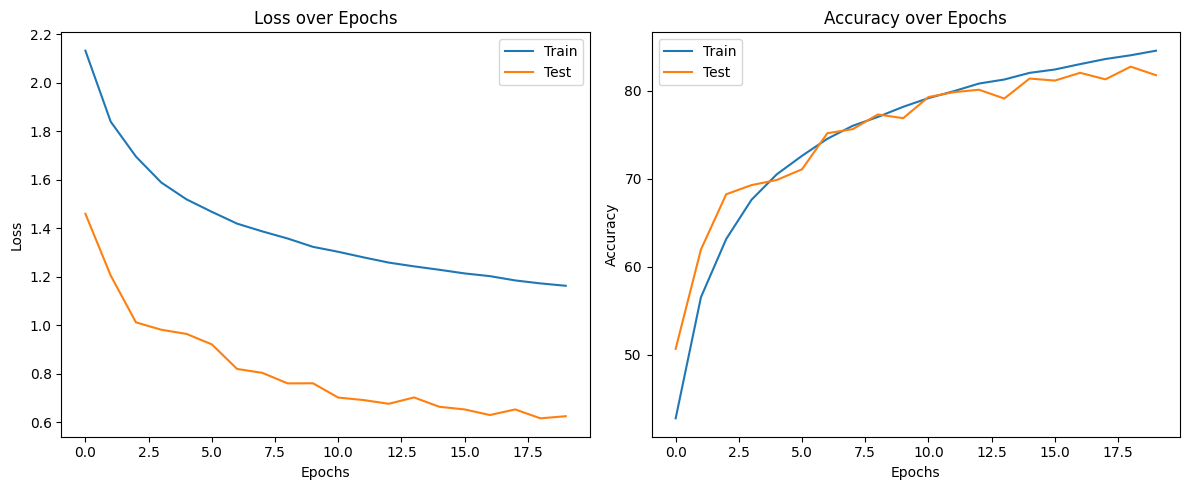

In [48]:
# Plotting the metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


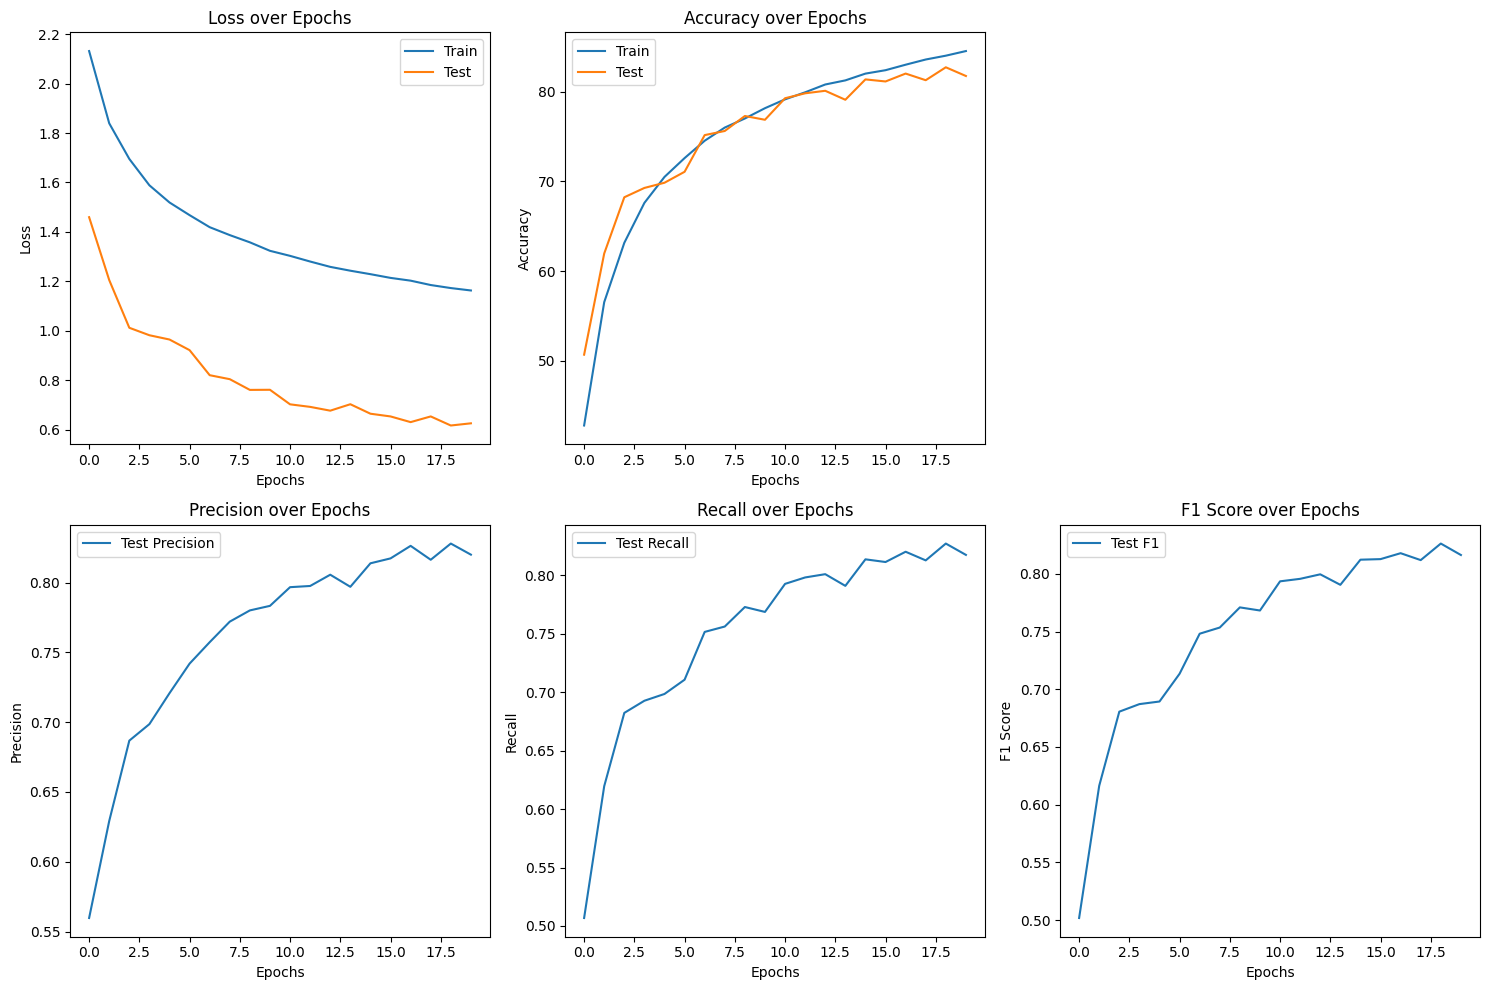

In [49]:
# Plotting the metrics
plt.figure(figsize=(15, 10))

# Plotting Loss
plt.subplot(2, 3, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(2, 3, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Precision
plt.subplot(2, 3, 4)
plt.plot(test_precisions, label='Test Precision')
plt.title('Precision over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plotting Recall
plt.subplot(2, 3, 5)
plt.plot(test_recalls, label='Test Recall')
plt.title('Recall over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Plotting F1
plt.subplot(2, 3, 6)
plt.plot(test_f1s, label='Test F1')
plt.title('F1 Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()
